# Building an Agent with LangGraph

Trong hướng dẫn này, chúng ta sẽ nâng cấp một chatbot bằng cách tích hợp công cụ tìm kiếm web, cho phép nó thực hiện tìm kiếm web như một phần chức năng của nó. Sự tích hợp này cho phép chatbot truy xuất thông tin cập nhật từ web, làm cho các phản hồi của nó chính xác và linh hoạt hơn.

**Mục tiêu chính**

1. Tích hợp công cụ tìm kiếm web: <br>
* Chúng ta sẽ xây dựng một agent liên kết một công cụ tìm kiếm web với một LLM (Large Language Model). Agent sẽ quyết định một cách thông minh khi nào gọi công cụ tìm kiếm web dựa trên đầu vào của người dùng.

1. Định tuyến có điều kiện bằng cách sử dụng Edges: <br>
* Học cách sử dụng các edges có điều kiện để định tuyến quy trình làm việc đến các node khác nhau dựa trên việc công cụ tìm kiếm web có được gọi hay không. Điều này đảm bảo xử lý hiệu quả các yêu cầu có thể hoặc không yêu cầu thông tin bên ngoài.
<br>

Đến cuối hướng dẫn này, bạn sẽ hiểu cách tích hợp công cụ tìm kiếm web với LLM và tạo một chatbot có khả năng tận dụng dữ liệu web theo thời gian thực một cách hiệu quả.


### Tavily Search API Tool

In [1]:
from dotenv import load_dotenv
_ = load_dotenv(dotenv_path='../.env')
from langchain_community.tools import TavilySearchResults

# Create search tool
tool = TavilySearchResults(
    max_results=3,
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # search_depth="advanced",
    # include_domains = []
    # exclude_domains = []
)


**2. Add the Tool to the Tool List**

* The search tool is added to a list ( `tools` ). In LangChain, multiple tools can be combined to build more advanced workflows.

In [2]:
tools = [tool]

In [3]:
tool.invoke("Tin nóng Hà Nội hôm nay")

[{'title': 'Hà Nội - Tin tức online 24h mới nhất hôm nay - Báo Mới',
  'url': 'https://baomoi.com/tin-dia-phuong/ha-noi.epi',
  'content': "Nóng\n\nMới\n\nVIDEO\n\nCHỦ ĐỀ\n\nHà Nội\n\nHà Nội nắng ấm dịp cuối tuần\n\nHà Nội hưởng ứng Giờ Trái đất 2025\n\nHà Nội trắng sắc hoa sưa\n\nKý họa hương vị phố cổ Hà Nội\n\nChỉ tiêu tuyển sinh của Đại học Quốc gia Hà Nội, .Dược Hà Nội, Học viện Tài chính\n\nHôm nay Hà Nội ngày nắng, đêm rét\n\nHà Nội tăng nhiệt, ấm dần lên\n\nHà Nội duy trì mạng lưới phòng chống lao\n\nGiá chung cư tại Hà Nội đang 'hạ nhiệt'\n\nHà Nội xây dựng Sàn giao dịch công nghệ\n\nHà Nội không để dịch sởi bùng phát [...] Hà Nội 'chốt' địa điểm đặt cột mốc Km0\n\nDừng tuyển dụng công chức, viên chức tại Hà Nội\n\nĐô thị Hà Nội trong kỷ nguyên mới\n\nSáng nay, Hà Nội ô nhiễm nhất thế giới\n\nHà Nội tạm dừng tổ chức thi tuyển viên chức\n\nTrải nghiệm Tết cổ truyền Azerbaijan tại Hà Nội\n\nHà Nội đảm bảo đủ vaccine tiêm phòng bệnh sởi",
  'score': 0.6069058417647059,
  'raw_con

### Adding bind_tools to Configure LLM + Tools

Trong phần này, chúng ta sẽ tích hợp `bind_tools` vào LLM để kích hoạt chức năng **LLM + Tools**.

Điều này cho phép LLM tận dụng các công cụ bên ngoài một cách linh hoạt và phản hồi hiệu quả hơn với đầu vào của người dùng.

**1. Define the State Schema**

- Lớp `State` đóng vai trò là lược đồ để lưu trữ và truyền trạng thái của đồ thị đến node tiếp theo.
- Sử dụng `TypedDict` và chú thích của Python, chúng ta định nghĩa thuộc tính `messages` là một danh sách hỗ trợ việc thêm tin nhắn mới thông qua hàm `add_messages` từ `LangGraph`.
- Mặc dù lược đồ có thể hỗ trợ các thuộc tính trạng thái bổ sung, hướng dẫn này chỉ tập trung vào `messages`.


In [4]:
from typing import Annotated, TypedDict 
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Define messages (a list type, with the add_messages function used to append messages)
    messages: Annotated[list, add_messages]

**2. Initialize the LLM and Bind Tools**

- Instance `ChatOllama` được khởi tạo làm LLM.
- Phương thức `bind_tools` sau đó được sử dụng để gắn một tập hợp các công cụ vào LLM, cho phép nó gọi các chức năng bên ngoài.

Bằng cách gắn công cụ tùy chỉnh chúng ta đã tạo, LLM có khả năng thực hiện tìm kiếm web, thêm khả năng phản hồi cho chatbot.


In [5]:
from langchain_ollama import ChatOllama
llm = ChatOllama(model='qwen2.5:7b', temperature=0)

llm_with_tools = llm.bind_tools(tools)

**3. Define a Node Function**

- Nodes là các khối xây dựng của đồ thị.
- Mỗi node đại diện cho một thao tác hoặc bước cụ thể trong quy trình.
- Ở đây, chúng ta định nghĩa một hàm node `chatbot` sử dụng instance `llm_with_tools` để xử lý `messages` đầu vào từ `State` và trả về danh sách messages được cập nhật.

Vì chức năng `add_messages` đã được áp dụng, nếu công cụ được coi là cần thiết trong quá trình xử lý, kết quả của lệnh gọi công cụ sẽ được lưu trữ trong `answer`. Kết quả này sau đó được tích lũy trong `messages` thông qua phương thức `add_messages`, duy trì luồng hội thoại được cập nhật.


In [6]:
def chatbot(state: State):
    print("-"*40)
    print("chatbot")
    print(f"{state=}")
    print("-"*40)
    # Invoke LLM with tools using the provided messages
    answer = llm_with_tools.invoke(state["messages"])
    # Return updated messages (add_messages applied automatically)
    return {"messages": [answer]}

**4. Create a Graph and Add Nodes**

- Tạo một instance `StateGraph` để biểu diễn quy trình làm việc và thêm node `chatbot` vào đó.


In [7]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)


## Tool Node

Tiếp theo, chúng ta cần tạo một hàm sẽ thực thi công cụ bất cứ khi nào nó được gọi.

Để đạt được điều này, chúng ta sẽ thêm một node mới được thiết kế đặc biệt để thực thi công cụ.

Chúng ta sẽ triển khai một `BasicToolNode` tùy chỉnh, node này kiểm tra tin nhắn gần đây nhất. Nếu tin nhắn bao gồm `tool_calls`, node sẽ thực thi công cụ tương ứng.

Mặc dù chúng ta đang triển khai thủ công điều này hiện tại, nhưng cần lưu ý rằng sau này, bạn có thể thay thế điều này bằng [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode) được xây dựng sẵn của LangGraph để thuận tiện hơn.


In [8]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # List of tools
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # Extract the most recent message if messages exist
        print("-"*40)
        print("BasicToolNode")
        print(f"{inputs=}")
        print("-"*40)
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # Results from tool calls
        outputs = []
        for tool_call in message.tool_calls:
            # Call the tool and store the result
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # Store the tool call result as a message
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # Convert tool call result to a string
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


 **Explanation of the Code**

1. **Mục đích của Code**
   - Đoạn code này định nghĩa một node công cụ (`BasicToolNode`) thực thi động các công cụ dựa trên hướng dẫn từ tin nhắn gần đây nhất trong danh sách đầu vào.

2. **Cách thức hoạt động**
   - **Khởi tạo (`__init__`)**:
     - Một danh sách các công cụ được truyền cho constructor của `BasicToolNode`.
     - Mỗi công cụ được lưu trữ trong một dictionary để tra cứu nhanh theo tên.
   - **Thực thi (`__call__`)**:
     - Khi node được gọi, nó xem xét tin nhắn gần đây nhất trong đầu vào được cung cấp (khóa `messages`).
     - Nó trích xuất các lệnh gọi công cụ từ tin nhắn và gọi các công cụ thích hợp bằng tên và đối số của chúng.
     - Kết quả được định dạng dưới dạng các đối tượng `ToolMessage` và được trả về.

3. **ToolMessage**
   - `ToolMessage` là một cách tiêu chuẩn hóa để lưu trữ và trả về kết quả thực thi công cụ, bao gồm tên công cụ, nội dung kết quả và ID duy nhất cho lệnh gọi công cụ.

4. **Thêm vào Đồ thị**
   - Node công cụ (`tool_node`) được thêm vào đồ thị bằng cách sử dụng `graph_builder.add_node`. Điều này tích hợp node vào một quy trình làm việc hoặc pipeline thực thi lớn hơn.

5. **Sử dụng**
   - Cấu trúc này thường là một phần của hệ thống lớn hơn, nơi các công cụ được gọi dựa trên đầu vào của người dùng hoặc logic hệ thống, và kết quả được trả về cho người dùng hoặc chuyển đến các node khác.


In [9]:
tool_node = BasicToolNode(tools=tools)

tool_node.tools_list

{'tavily_search_results_json': TavilySearchResults(max_results=3, include_answer=True, include_raw_content=True, include_images=True, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}

In [10]:
graph_builder.add_node("tools", tool_node)

In [11]:
graph_builder.nodes

{'chatbot': StateNodeSpec(runnable=chatbot(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class '__main__.State'>, retry_policy=None, ends=()),
 'tools': StateNodeSpec(runnable=tools(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class '__main__.State'>, retry_policy=None, ends=())}

## Conditional Edge

Khi nút công cụ (tool node) được thêm vào, bạn có thể định nghĩa `conditional_edges` để kiểm soát luồng thực thi trong đồ thị.
- Edges (Cạnh): Chúng định tuyến luồng điều khiển từ một nút này sang nút tiếp theo trong một đồ thị.
- Conditional Edges (Cạnh điều kiện): Đây là các cạnh với logic "if" xác định nút tiếp theo dựa trên `state` (trạng thái) đồ thị hiện tại. Các hàm này nhận `state` đồ thị hiện tại làm đầu vào và trả về tên của nút tiếp theo (hoặc danh sách các nút).

Trong ví dụ dưới đây, chúng ta định nghĩa một hàm router `route_tools` kiểm tra đầu ra của chatbot cho `tool_calls`.

Hàm này được truyền vào đồ thị bằng cách sử dụng `add_conditional_edges`. Mỗi khi nút `chatbot` hoàn thành thực thi, hàm sẽ xác định nơi đi tiếp theo:
- Nếu có một lệnh gọi công cụ (tool call), nó sẽ định tuyến đến nút `tools`.
- Nếu không có lệnh gọi công cụ (tool call), nó sẽ định tuyến đến nút `END`, kết thúc luồng.

Điều này có thể được thay thế bằng [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) được xây dựng sẵn có sẵn trong LangGraph.


### add_conditional_edges method


<img src="../images/03-langgraph-agent-conditional-edge.png" width="500" />

Phương thức `add_conditional_edges` thêm logic điều kiện vào đồ thị. Dưới đây là phân tích các tham số và chức năng của nó:

**Tham số**
- `source` ( `str` ): Nút bắt đầu nơi cạnh điều kiện xuất phát.
- `path` ( `Callable` ): Một hàm hoặc đối tượng callable xác định (các) nút tiếp theo. Nó nhận trạng thái hiện tại làm đầu vào và trả về một hoặc nhiều tên nút.
- `path_map` ( `dict` hoặc `list` ): Ánh xạ đầu ra của `path` tới các nút cụ thể trong đồ thị. Nếu bị bỏ qua, đầu ra của `path` phải tương ứng trực tiếp với tên nút.
- `then` ( `Optional[str]` ): Chỉ định nút sẽ được thực thi sau nút được chọn bởi path.

**Giá trị trả về**
- Trả về chính đối tượng đồ thị để thực hiện method chaining.

**Các tính năng chính của `add_conditional_edges`**
- Dynamic Flow Control (Kiểm soát luồng động): Cho phép bạn định nghĩa logic để thay đổi luồng một cách động dựa trên trạng thái.

- Path Mapping (Ánh xạ đường dẫn): Chuyển đổi đầu ra của hàm `path` thành các nút đồ thị cụ thể.

- Error Handling (Xử lý lỗi): Gây ra `ValueError` nếu:
    - Hàm `path` thiếu type hint hoặc `path_map`.
    - Một nhánh có cùng tên đã tồn tại.
- Graph Visualization (Trực quan hóa đồ thị): Sau khi đồ thị được định nghĩa, nó có thể được trực quan hóa bằng phương thức sau.


In [12]:
from langgraph.graph import START, END

# Define the router function
def route_tools(state: State):
    print("-"*40)
    print("route_tools")
    print(f"{state=}")
    print("-"*40)
    if messages := state.get("messages", []):
        # Extract the most recent AI message
        ai_message = messages[-1]
    else:
        # Raise an error if no messages are found
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # Check for tool calls in the AI message
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # If there are tool calls, route to "tools"
        return "tools"
    # If no tool calls, route to "END"
    return END
    
# Add conditional edges to the graph
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # Map the returned values to specific nodes
    path_map={"tools": "tools", END: END},
)

# Define additional edges
graph_builder.add_edge("tools", "chatbot")  # Return to chatbot after tools
graph_builder.add_edge(START, "chatbot")    # Start with the chatbot node

# Compile the graph
graph = graph_builder.compile()

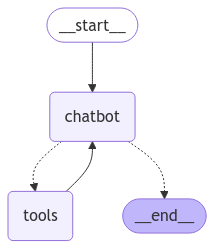

In [13]:
graph

In [14]:
inputs = {"messages": "Search for information about the TED YouTube channel"}

for event in graph.stream(inputs, stream_mode="values"):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        # display_message_tree(value["messages"][-1])
        print(value[-1])


STEP: messages

content='Search for information about the TED YouTube channel' additional_kwargs={} response_metadata={} id='39efdd8b-64aa-4fe4-b894-50926d08f261'
----------------------------------------
chatbot
state={'messages': [HumanMessage(content='Search for information about the TED YouTube channel', additional_kwargs={}, response_metadata={}, id='39efdd8b-64aa-4fe4-b894-50926d08f261')]}
----------------------------------------
----------------------------------------
route_tools
state={'messages': [HumanMessage(content='Search for information about the TED YouTube channel', additional_kwargs={}, response_metadata={}, id='39efdd8b-64aa-4fe4-b894-50926d08f261'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5:7b', 'created_at': '2025-03-22T07:18:33.9182598Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3251331000, 'load_duration': 2600214800, 'prompt_eval_count': 195, 'prompt_eval_duration': 217313400, 'eval_count': 26, 'eval_duration'

### Illustration of the structure after a tool call

Sơ đồ này minh họa cấu trúc của một "Tool Message" (Tin nhắn Công cụ) trong quy trình làm việc của chatbot, cho thấy cách dữ liệu liên quan đến công cụ (chẳng hạn như lệnh gọi công cụ, đối số và siêu dữ liệu) được tổ chức và ghi lại trong quá trình gọi công cụ.

![Illustration of the structure after a tool call](../images/03-langgraph-agent-diagram.png)

## Full code

In [15]:
del graph_builder
del graph

In [16]:
import json
from dotenv import load_dotenv
_ = load_dotenv(dotenv_path='../.env')

from langchain_community.tools import TavilySearchResults
from typing import Annotated, TypedDict 
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_ollama import ChatOllama
from langchain_core.messages import ToolMessage

class State(TypedDict):
    # Define messages (a list type, with the add_messages function used to append messages)
    messages: Annotated[list, add_messages]

# Create search tool
tool = TavilySearchResults(
    max_results=3,
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # search_depth="advanced",
    # include_domains = []
    # exclude_domains = []
)
tools = [tool]
llm = ChatOllama(model='qwen2.5:7b', temperature=0)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    # Invoke LLM with tools using the provided messages
    answer = llm_with_tools.invoke(state["messages"])
    # Return updated messages (add_messages applied automatically)
    return {"messages": [answer]}

class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # List of tools
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # Extract the most recent message if messages exist
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # Results from tool calls
        outputs = []
        for tool_call in message.tool_calls:
            # Call the tool and store the result
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # Store the tool call result as a message
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # Convert tool call result to a string
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}
    
# Define the router function
def route_tools(state: State):
    if messages := state.get("messages", []):
        # Extract the most recent AI message
        ai_message = messages[-1]
    else:
        # Raise an error if no messages are found
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    # Check for tool calls in the AI message
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # If there are tool calls, route to "tools"
        return "tools"
    # If no tool calls, route to "END"
    return END



tool_node = BasicToolNode(tools=tools)

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
# Add conditional edges to the graph
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # Map the returned values to specific nodes
    path_map={"tools": "tools", END: END},
)
# Define additional edges
graph_builder.add_edge("tools", "chatbot")  # Return to chatbot after tools
graph_builder.add_edge(START, "chatbot")    # Start with the chatbot node

# Compile the graph
graph = graph_builder.compile()

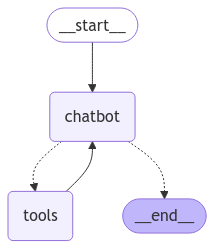

In [17]:
graph

In [18]:
response = llm_with_tools.invoke("Search for information about the TED YouTube channel")

In [19]:
response.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'TED YouTube channel'},
  'id': '5e637e9c-3c08-4427-9824-c59174862a80',
  'type': 'tool_call'}]